<a href="https://colab.research.google.com/github/holly-hewitt/Abnormal-Infant-Movement-Detection/blob/main/Feature_Windows_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


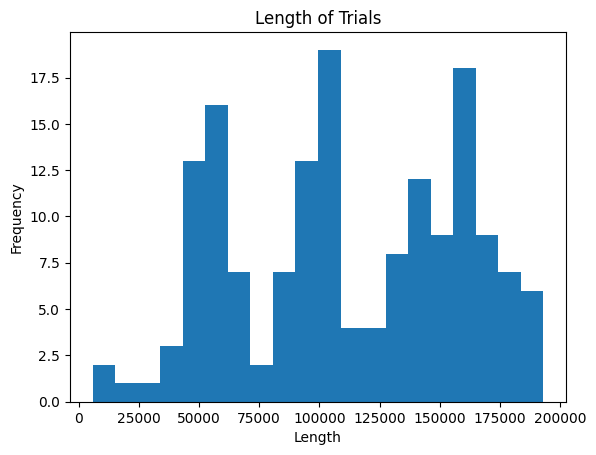

In [ ]:
# import libraries
#import tensorflow.compat.v1 as tf
#tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True))
#tf.test.gpu_device_name()
#tf.config.run_functions_eagerly(True)

#!pip install optuna
#!pip install optuna-integration

import tensorflow as tf
# Standard library imports
import datetime
import pickle
import gc

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.preprocessing import StandardScaler



# Keras/TensorFlow imports
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D, Normalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2


tf.get_logger().setLevel('ERROR')

from google.colab import drive
drive.mount('/content/drive')

# open accelData pickle
with open('drive/MyDrive/Pickles/accelData.pickle', 'rb') as handle:
    accelData = pickle.load(handle)

# Remove time column from accelData Measurements
for i in range(len(accelData['Measurements'])):
    accelData['Measurements'][i] = accelData['Measurements'][i].iloc[:, 1:]

# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
for i in range(1):
    K = 14

    # Split some of the longer trials in half
    numRowsAccel = [df.shape[0] for df in accelData['Measurements']]
    sortedIndices = np.argsort(numRowsAccel)

    # Get the indices of the top k dataframes
    topKIndices = sortedIndices[-K:]

    # Get the top k dataframes
    topKDataframes = [accelData['Measurements'][i] for i in topKIndices]

    # Get the top k corresponding months, IDs, labels
    topKMonths = [accelData['Month'][i] for i in topKIndices]
    topKCodes = [accelData['Code'][i] for i in topKIndices]
    topKAbnormal = [accelData['Abnormal'][i] for i in topKIndices]
    topKAIMS = [accelData['AIMS'][i] for i in topKIndices]
    topKOptimality = [accelData['Optimality'][i] for i in topKIndices]

    # Remove the dataframes from accelData
    for i in sorted(topKIndices, reverse=True):
        del accelData['Measurements'][i]
        del accelData['Month'][i]
        del accelData['Code'][i]
        del accelData['Abnormal'][i]
        del accelData['AIMS'][i]
        del accelData['Optimality'][i]

    # Split the top k dataframes into two and reinsert into structure
    for i in range(len(topKDataframes)):
        df = topKDataframes[i]
        month = topKMonths[i]
        code = topKCodes[i]
        abnormal = topKAbnormal[i]
        aims = topKAIMS[i]
        optimality = topKOptimality[i]

        first_half = df.iloc[0:df.shape[0]//2]
        second_half = df.iloc[df.shape[0]//2:df.shape[0]]

        # Append the first and second halves to accelData
        accelData['Measurements'].append(first_half)
        accelData['Measurements'].append(second_half)

        # Append the corresponding values for month, code, abnormal, aims, and optimality
        accelData['Month'].extend([month, month])
        accelData['Code'].extend([code, code])
        accelData['Abnormal'].extend([abnormal, abnormal])
        accelData['AIMS'].extend([aims, aims])
        accelData['Optimality'].extend([optimality, optimality])

    # PLot histogram of length of trials
    lengths = [len(accelData['Measurements'][i]) for i in range(len(accelData['Measurements']))]
    plt.hist(lengths, bins=20)
    plt.title("Length of Trials")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.show()

    # Memory management
    del numRowsAccel, sortedIndices, topKIndices, topKDataframes, topKMonths, topKCodes, topKAbnormal, topKAIMS, topKOptimality, first_half, second_half, df, month, code, abnormal, aims, optimality

# start making visualizations of the data.
try:
    i = accelData['Abnormal'].index(0.5)

    del accelData['Measurements'][i], accelData['Month'][i], accelData['Code'][i], accelData['Abnormal'][i], accelData['AIMS'][i], accelData['Optimality'][i]
except:
    pass


# get specific rows from dataframes in accelData Measurements
RA_cols = ['AccXRA', 'AccYRA', 'AccZRA']
LA_cols = ['AccXLA', 'AccYLA', 'AccZLA']
RW_cols = ['AccXRW', 'AccYRW', 'AccZRW']
LW_cols = ['AccXLW', 'AccYLW', 'AccZLW']


sum_cols = ['AccSumRA', 'AccSumLA', 'AccSumRW', 'AccSumLW']

#sum = [df[sum_cols] for df in accelData['Measurements']]

abnormal = accelData['Abnormal']
AIMS = accelData['AIMS']
Optimality = accelData['Optimality']
measurements = accelData['Measurements']



measurements_nosum_cols = ['AccXRA', 'AccYRA', 'AccZRA', 'AccXLA', 'AccYLA', 'AccZLA', 'AccXRW', 'AccYRW', 'AccZRW', 'AccXLW', 'AccYLW', 'AccZLW']
measurements_nosum = [df[measurements_nosum_cols] for df in accelData['Measurements']]

del accelData


In [ ]:

standardised = []
for df in measurements_nosum:
    scaler = StandardScaler()
    array = scaler.fit_transform(df)
    standardised_df = pd.DataFrame(array, columns=df.columns, index=df.index)
    standardised.append(standardised_df)

normalised = []
for df in measurements_nosum:
    scaler = MinMaxScaler()
    array = scaler.fit_transform(df)  # Fit and transform the data
    normalised_df = pd.DataFrame(array, columns=df.columns, index=df.index)  # Create a new DataFrame
    normalised.append(normalised_df)


In [ ]:
def prepare_data(trials, labels, window_size, stride):
    all_windows = []
    all_labels = []

    # Loop over each trial and its corresponding label
    for trial, label in zip(trials, labels):
        # Create windows for the current trial
        windows = create_windows(trial, window_size, stride)

        # Extend the list of all windows with the newly created windows
        all_windows.extend(windows)

        # Extend the list of all labels with the current label repeated for each window created from the current trial
        all_labels.extend([label] * len(windows))

    return all_windows, all_labels

def create_windows(data, window_size, stride):
    return [data[i:i + window_size] for i in range(0, len(data) - window_size, stride)]

In [ ]:
import numpy as np
import pandas as pd

def statistical_Features_optimized(windows):
    all_features = []
    total_windows = len(windows)
    # Pre-calculate these functions across all windows to avoid repeated calculations
    for i, window in enumerate(windows):
        # Calculate all statistics at once using pandas' built-in functions
        # This avoids the need for explicit loops over columns

        mean = window.mean()
        SD = window.std()
        variance = window.var()
        median = window.median()
        skewness = window.skew()
        kurtosis = window.kurt()
        rnge = window.max() - window.min()
        rms = np.sqrt((window**2).mean())

        # Combine all features
        features = np.vstack([mean, SD, variance, median, skewness, kurtosis, rnge, rms])
        all_features.append(features.T) # Transpose to match the original shape expectation


    return all_features

In [ ]:
window_stride_pairs = [(100, 50), (200, 100), (400, 200), (600,300), (800, 400), (1000, 500)]

filenames = ['w100s50features',
             'w200s100features',
             'w400s200features',
             'w600s300features',
             'w800s400features',
             'w1000s500features',
             ]

for i, pair in enumerate(window_stride_pairs):
    w = pair[0]
    s = pair[1]
    all_window_features = []
    for j, trial in enumerate(measurements_nosum):
        windows = create_windows(trial, window_size=w, stride=s)
        all_features = statistical_Features_optimized(windows)
        all_window_features.append(all_features)
        print(f"Processed {j} trials ({(j+1) / len(measurements_nosum) * 100:.2f}% completed)")

    with open(f'drive/MyDrive/Pickles/{filenames[i]}.pickle', 'wb') as f:
        pickle.dump(all_window_features, f)

Processed 0 trials (0.62% completed)
Processed 1 trials (1.25% completed)
Processed 2 trials (1.88% completed)
Processed 3 trials (2.50% completed)
Processed 4 trials (3.12% completed)
Processed 5 trials (3.75% completed)
Processed 6 trials (4.38% completed)
Processed 7 trials (5.00% completed)
Processed 8 trials (5.62% completed)
Processed 9 trials (6.25% completed)
Processed 10 trials (6.88% completed)
Processed 11 trials (7.50% completed)
Processed 12 trials (8.12% completed)
Processed 13 trials (8.75% completed)
Processed 14 trials (9.38% completed)
Processed 15 trials (10.00% completed)
Processed 16 trials (10.62% completed)
Processed 17 trials (11.25% completed)
Processed 18 trials (11.88% completed)
Processed 19 trials (12.50% completed)
Processed 20 trials (13.12% completed)
Processed 21 trials (13.75% completed)
Processed 22 trials (14.37% completed)
Processed 23 trials (15.00% completed)
Processed 24 trials (15.62% completed)
Processed 25 trials (16.25% completed)
Processed 2

In [ ]:
window_stride_pairs = [(100, 50)]

filenames = ['w100s50featuresStand']


for i, pair in enumerate(window_stride_pairs):
    w = pair[0]
    s = pair[1]
    all_window_features = []
    for j, trial in enumerate(standardised):
        windows = create_windows(trial, window_size=w, stride=s)
        all_features = statistical_Features_optimized(windows)
        all_window_features.append(all_features)
        print(f"Processed {j} trials ({(j+1) / len(measurements_nosum) * 100:.2f}% completed)")

    with open(f'drive/MyDrive/Pickles/{filenames[i]}.pickle', 'wb') as f:
        pickle.dump(all_window_features, f)

Processed 0 trials (0.62% completed)
Processed 1 trials (1.25% completed)
Processed 2 trials (1.88% completed)
Processed 3 trials (2.50% completed)
Processed 4 trials (3.12% completed)
Processed 5 trials (3.75% completed)
Processed 6 trials (4.38% completed)
Processed 7 trials (5.00% completed)
Processed 8 trials (5.62% completed)
Processed 9 trials (6.25% completed)
Processed 10 trials (6.88% completed)
Processed 11 trials (7.50% completed)
Processed 12 trials (8.12% completed)
Processed 13 trials (8.75% completed)
Processed 14 trials (9.38% completed)
Processed 15 trials (10.00% completed)
Processed 16 trials (10.62% completed)
Processed 17 trials (11.25% completed)
Processed 18 trials (11.88% completed)
Processed 19 trials (12.50% completed)
Processed 20 trials (13.12% completed)
Processed 21 trials (13.75% completed)
Processed 22 trials (14.37% completed)
Processed 23 trials (15.00% completed)
Processed 24 trials (15.62% completed)
Processed 25 trials (16.25% completed)
Processed 2

In [ ]:
window_stride_pairs = [(100, 50)]

filenames = ['w100s50featuresNorm']


for i, pair in enumerate(window_stride_pairs):
    w = pair[0]
    s = pair[1]
    all_window_features = []
    for j, trial in enumerate(normalised):
        windows = create_windows(trial, window_size=w, stride=s)
        all_features = statistical_Features_optimized(windows)
        all_window_features.append(all_features)
        print(f"Processed {j} trials ({(j+1) / len(measurements_nosum) * 100:.2f}% completed)")

    with open(f'drive/MyDrive/Pickles/{filenames[i]}.pickle', 'wb') as f:
        pickle.dump(all_window_features, f)

Processed 0 trials (0.62% completed)
Processed 1 trials (1.25% completed)
Processed 2 trials (1.88% completed)
Processed 3 trials (2.50% completed)
Processed 4 trials (3.12% completed)
Processed 5 trials (3.75% completed)
Processed 6 trials (4.38% completed)
Processed 7 trials (5.00% completed)
Processed 8 trials (5.62% completed)
Processed 9 trials (6.25% completed)
Processed 10 trials (6.88% completed)
Processed 11 trials (7.50% completed)
Processed 12 trials (8.12% completed)
Processed 13 trials (8.75% completed)
Processed 14 trials (9.38% completed)
Processed 15 trials (10.00% completed)
Processed 16 trials (10.62% completed)
Processed 17 trials (11.25% completed)
Processed 18 trials (11.88% completed)
Processed 19 trials (12.50% completed)
Processed 20 trials (13.12% completed)
Processed 21 trials (13.75% completed)
Processed 22 trials (14.37% completed)
Processed 23 trials (15.00% completed)
Processed 24 trials (15.62% completed)
Processed 25 trials (16.25% completed)
Processed 2